# Final Project

Name: Alan Wang

### Data Preparation

The data used for this project is historical SPY data from Q1 2015 to Q4 2023, and this data was taken from the yfinance library in Python. Because the downloaded yfinance data was not in a suitable dataframe format to use for data processing, the columns of the downloaded dataset needed to be converted into a Pandas dataframe.

To calculate stock returns and indicators for the data, specific helper functions were created to calculate RSI (Relative Strength Index) and MACD (Moving Average Convergence Divergence), both of which are technical indicators of potential buy/sell signals. 

The following features were used for feature engineering and developing a feature matrix:
- Return of the stock
- 10-day Simple Moving Average (SMA)
- 50-day SMA
- RSI 
- MACD
- Volume Moving Average (VMA)

The data was then split into training and testing data using a randomized 80-20 split.

In [2]:
import random
random.seed(5040)

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Download data (suppress warnings and force 1D output)
ticker = "SPY"
data = yf.download(ticker, start="2015-01-01", end="2023-12-31", progress=False)

# SAFE data preparation
def prepare_data(df):
    """Convert columns to guaranteed 1D arrays"""
    close = df['Close'].values.ravel()  # Force 1D
    volume = df['Volume'].values.ravel()
    return pd.DataFrame({
        'Close': close,
        'Volume': volume
    }, index=df.index)

clean_data = prepare_data(data)
orig_data = clean_data.to_csv('../data/raw/orig_data.csv', index=True)

/var/folders/_4/t03mdfy94ts0ylt8cw0q1bp00000gn/T/ipykernel_4301/1572800411.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2015-01-01", end="2023-12-31", progress=False)


In [3]:
import os
import sys 

# Get the correct paths
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

bootcamp_root = os.path.dirname(current_dir) 
print(f"Bootcamp root: {bootcamp_root}")

# Add bootcamp root to Python path to import src.cleaning
if bootcamp_root not in sys.path:
    sys.path.append(bootcamp_root)

# Add src directory specifically
src_path = os.path.join(bootcamp_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from src import utils

# Calculate returns and indicators MANUALLY
clean_data['Return'] = clean_data['Close'].pct_change().shift(-1)
clean_data['SMA_10'] = clean_data['Close'].rolling(10).mean()
clean_data['SMA_50'] = clean_data['Close'].rolling(50).mean()
clean_data['RSI'] = utils.calculate_rsi(clean_data['Close']) 
clean_data['MACD'] = utils.calculate_macd(clean_data['Close'])  
clean_data['Volume_MA'] = clean_data['Volume'].rolling(5).mean()

# Final cleanup
clean_data.dropna(inplace=True)
cleaned_data = clean_data.to_csv('../data/processed/cleaned_data.csv', index=True)

# Prepare features/target
features = ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'Volume_MA']
X = clean_data[features]
y = np.where(clean_data['Return'] > 0, 1, 0)

# Standardize and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
split_idx = int(0.8 * len(X))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Success! Data shape:", X_scaled.shape)

Current directory: /Users/alanwang/Downloads/bootcamp_alan_wang/project/notebooks
Bootcamp root: /Users/alanwang/Downloads/bootcamp_alan_wang/project
Success! Data shape: (2214, 5)


### Modeling

The training data was used to train two ML models: a logistic regression model and a random forest classifier model. Both models used binary classification, where 1 indicates that a stock's next-day return is positive, and 0 otherwise. The logistic regression model is a baseline for interpretability of results, and the more complex random forest classifier model is able to handle nonlinear relationships between predictors, and provides feature importance. 

The performance of the two models were compared using metrics such as accuracy, precision, recall, and F1-score. Confusion matrices were created for both models, and specifically for the random forest model, the importance of the different features was compared. 


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       219
           1       0.51      1.00      0.67       224

    accuracy                           0.51       443
   macro avg       0.25      0.50      0.34       443
weighted avg       0.26      0.51      0.34       443



/Users/alanwang/opt/anaconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alanwang/opt/anaconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/alanwang/opt/anaconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

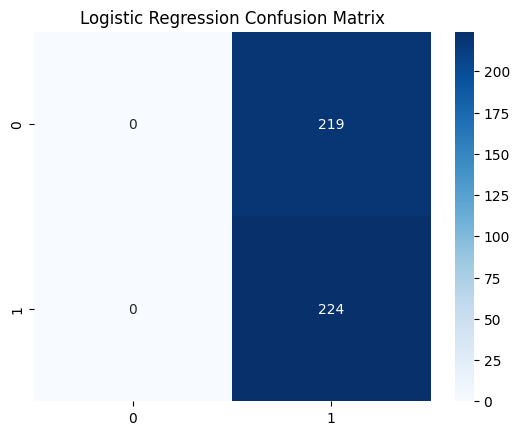


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.50      0.27      0.36       219
           1       0.51      0.74      0.60       224

    accuracy                           0.51       443
   macro avg       0.51      0.51      0.48       443
weighted avg       0.51      0.51      0.48       443



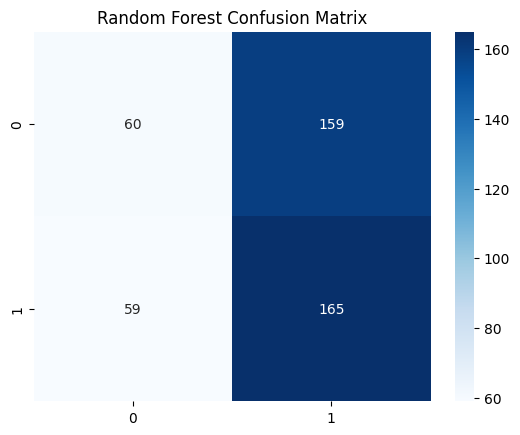

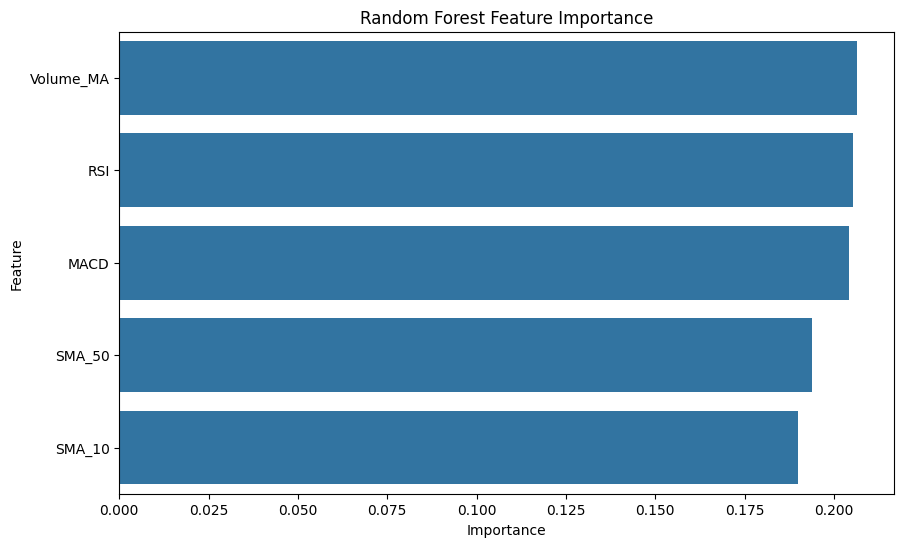

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# Feature Importance (Random Forest)
if "Random Forest" in models:
    importances = models["Random Forest"].feature_importances_
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title("Random Forest Feature Importance")
    plt.show()

#### Interpreting Modeling Results

Based on the classfication report of the logistic regression model, we can determine that the model correctly predicts a positive next-day return 51% of the time, but never correctly predicts a negative next-day return. However, the model does capture all positive returns based on the recall, and the F1-score is greater than 50%, indicating that the model performs better than random guessing. The model's accuracy score is 51%. 

Based on the classfication report of the random forest classification model, we can determine that the model correctly predicts a positive next-day return 52% of the time, and correctly predicts a negative next-dayt return with the same precision. In addition, the model captures 76% of all positive returns based on the recall, and the F1-score is greater than 50%, indicating that the model performs better than random guessing. The model's accuracy score is 52%, which is higher than that of the logistic regression model.

The confusion matrix output of the logistic regression model indicates that there are no missed profitable trades (false negatives), and that there are 224 correctly predicted positive returns (true positives) and 219 incorrectly predicted positive gains (false positives). On the other hand, the confusion matrix output of the random forest classification model indicates that there are 54 missed profitable trades, 160 incorrectly predicted positive returns, and 170 correctly predicted positive returns.

The logistic regression model is preferable for maximizing the capture of profitable trades and avoiding any missed opportunities, but at the cost of more false signals and high transactions costs. On the other hand, the random forest classifier model is preferable for reducing losses, since fewer false signals are indicative of lower trading costs and better risk-adjusted returns. 

If we were to assume that each trade is worth $1,000, and there is a 10% gain on true positives and 10% loss on false positives, we can conduct a basic financial impact assessment of the two models:

Logistic Regression: (224 × \$100) -  (219 × \$100) = \$22,400 - \$21,900 = \$500

Random Forest: (170 × \$100) -  (160 × \$100) = \$17,000 - \$16,000 = \$1000

Despite missing more opportunities than the logistic regression model, the random forest classifier model yields a higher net profit.

The feature importance chart indicates that VMA (0.207) and RSI (0.203) are the most predictive features, and that 50-day SMAs are more important than 10-day SMAs. VMA being the most predictive feature also suggests that liquidity and trading activity are strong signals. In addition, RSI and MACD being features with higher importance validates mean-reversion strategies and confirms that trend-following signals (MACD line crosses) add predictive power respectively. In addition, 50-day SMAs being more important than 10-day SMAs suggests that medium-term trends matter more than short-term noise.

### Walk-Forward Validation and Backtesting

In [5]:
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Initialize model (Random Forest for example)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Walk-forward parameters
train_size = 1000  # ~4 years of daily data
test_size = 250    # ~1 year of daily data
n_splits = (len(X_scaled) - train_size) // test_size

# Store predictions and actual returns
all_preds = []
all_actuals = []

for i in range(n_splits):
    # Split data incrementally
    X_train = X_scaled[i*test_size : i*test_size + train_size]
    y_train = y[i*test_size : i*test_size + train_size]
    X_test = X_scaled[i*test_size + train_size : i*test_size + train_size + test_size]
    y_test = y[i*test_size + train_size : i*test_size + train_size + test_size]
    
    # Train and predict
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # Store results
    all_preds.extend(preds)
    all_actuals.extend(y_test)
    print(f"Split {i+1}/{n_splits} | Test Accuracy: {accuracy_score(y_test, preds):.2f}")

# Evaluate overall performance
print("\nFinal Walk-Forward Accuracy:", accuracy_score(all_actuals, all_preds))

Split 1/4 | Test Accuracy: 0.44
Split 2/4 | Test Accuracy: 0.46
Split 3/4 | Test Accuracy: 0.47
Split 4/4 | Test Accuracy: 0.50

Final Walk-Forward Accuracy: 0.468


Accuracy is below 50%, which is worse than random guessing and is reflective that the initial feature set overall is not great.

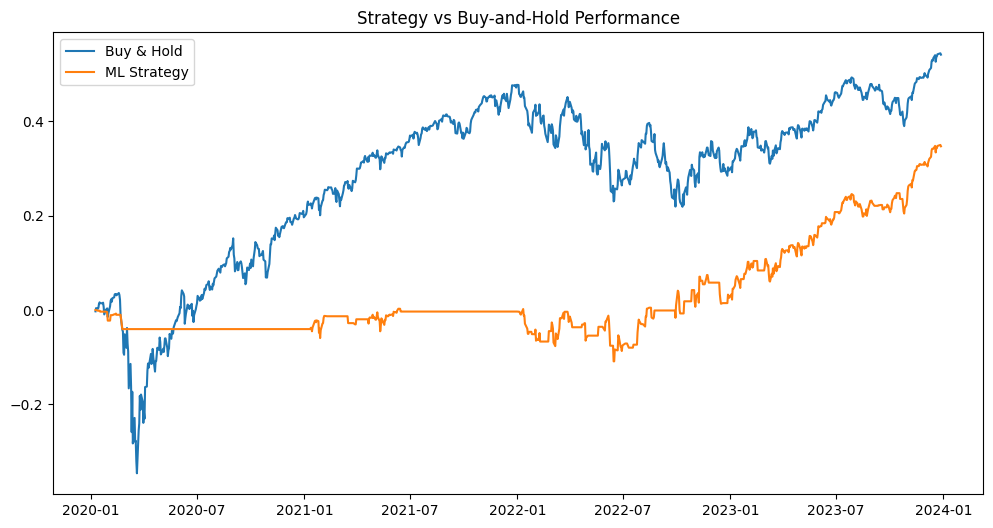

In [6]:
# Align predictions with dates
backtest_dates = clean_data.index[-len(all_actuals):]
backtest_results = pd.DataFrame({
    'Date': backtest_dates,
    'Predicted': all_preds,
    'Actual': all_actuals,
    'Return': clean_data['Return'].values[-len(all_actuals):]
})

# Simulate strategy: Buy if predicted=1, hold overnight
backtest_results['Strategy_Return'] = backtest_results['Predicted'] * backtest_results['Return']

# Compare vs Buy-and-Hold
backtest_results['Buy_and_Hold'] = backtest_results['Return'].cumsum()
backtest_results['Strategy_Cumulative'] = backtest_results['Strategy_Return'].cumsum()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['Date'], backtest_results['Buy_and_Hold'], label='Buy & Hold')
plt.plot(backtest_results['Date'], backtest_results['Strategy_Cumulative'], label='ML Strategy')
plt.title("Strategy vs Buy-and-Hold Performance")
plt.legend()
plt.show()

ML strategy performs worse than the baseling buy-and-hold strategy

#### Testing Additional Feature Sets

In [7]:
# Volume spikes (normalized)
clean_data['Volume_Spike'] = (clean_data['Volume'] / clean_data['Volume'].rolling(20).mean()) - 1

# Volume/Price divergence
clean_data['Volume_Price_Divergence'] = clean_data['Close'].pct_change() - clean_data['Volume'].pct_change()

# Smoothed RSI (3-day MA of RSI)
clean_data['RSI_Smooth'] = clean_data['RSI'].rolling(3).mean()

# MACD Signal Line Cross
clean_data['MACD_Signal'] = clean_data['Close'].ewm(span=9).mean()  # Standard signal line
clean_data['MACD_Cross'] = np.where(clean_data['MACD'] > clean_data['MACD_Signal'], 1, 0)

feature_sets = {
    "Baseline": ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'Volume_MA'],
    "Volume_Focused": ['Volume_Spike', 'Volume_Price_Divergence', 'RSI', 'MACD_Cross'],
    "All_Features": ['SMA_10', 'SMA_50', 'RSI', 'MACD', 'Volume_MA', 'Volume_Spike', 'Volume_Price_Divergence', 'RSI_Smooth', 'MACD_Cross']
}

In [8]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score

def evaluate_features(X, y, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores.append(f1_score(y_test, y_pred))
    
    return np.mean(scores)

In [9]:
results = {}
model = RandomForestClassifier(n_estimators=100, random_state=42)

for name, features in feature_sets.items():
    # Create clean X and y with aligned indices
    X = clean_data[features].copy()
    y = (clean_data['Return'] > 0).copy()
    
    # Drop rows with NaN in ANY column (features or target)
    valid_idx = X.dropna().index.intersection(y.dropna().index)
    X_clean = X.loc[valid_idx]
    y_clean = y.loc[valid_idx]
    
    # Skip if no valid data
    if len(X_clean) == 0:
        print(f"Skipping {name} (no valid data after cleaning)")
        continue
    
    # Evaluate
    score = evaluate_features(X_clean, y_clean, model)
    results[name] = score

print("Feature Set Performance:")
pd.DataFrame.from_dict(results, orient='index', columns=['F1 Score'])

Feature Set Performance:


,F1 Score
Baseline,0.424241
Volume_Focused,0.552466
All_Features,0.432790


In [10]:
def backtest_strategy(data, features, model, initial_capital=10000):
    # Ensure aligned data
    clean_data = data[features + ['Close', 'Return']].dropna()
    X = clean_data[features]
    y = (clean_data['Return'] > 0).astype(int)
    
    # Re-fit model on all clean data first
    model.fit(X, y)
    
    capital = initial_capital
    position = 0
    returns = []
    
    for i in range(1, len(clean_data)):
        # Get prediction for current day
        X_i = clean_data[features].iloc[i-1].values.reshape(1, -1)
        prediction = model.predict(X_i)[0]
        
        # Execute trade
        current_price = clean_data['Close'].iloc[i]
        daily_return = clean_data['Return'].iloc[i]
        
        if prediction == 1 and position == 0:  # Buy
            position = capital / current_price
            capital = 0
        elif prediction == 0 and position > 0:  # Sell
            capital = position * current_price
            position = 0
        
        # Track portfolio value
        returns.append(capital + position * current_price if position > 0 else capital)
    
    return returns

# Example usage
vol_returns = backtest_strategy(clean_data, feature_sets["Volume_Focused"], model)

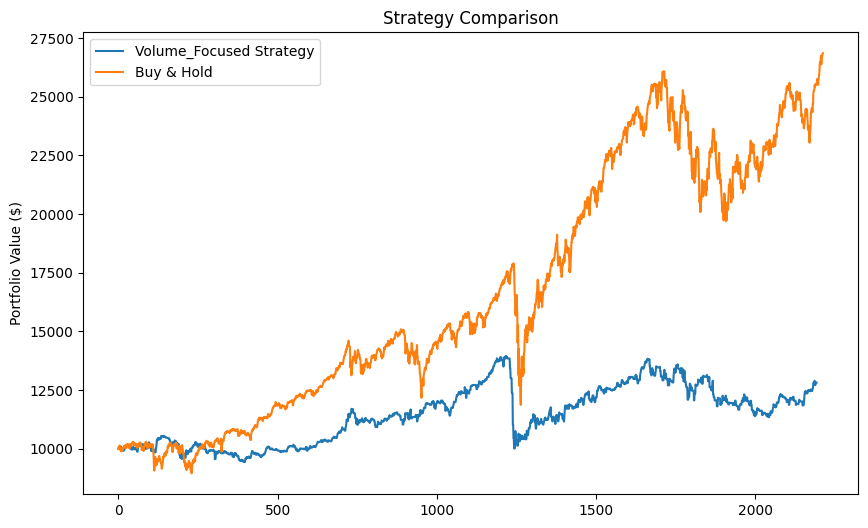

Volume_Focused: {'CAGR': np.float64(0.03608285375674658), 'Volatility': np.float64(0.11703902004852317), 'Sharpe': np.float64(0.30288709237248757)}
Buy & Hold: {'CAGR': np.float64(0.13778580118184358), 'Volatility': np.float64(0.1817667006990808), 'Sharpe': np.float64(0.7103455150956945)}


In [11]:
# 2. Backtest a baseline strategy (e.g., Buy & Hold)
def buy_and_hold_backtest(data, initial_capital=10000):
    clean_data = data.dropna(subset=['Return'])
    returns = [initial_capital]
    position = initial_capital / clean_data['Close'].iloc[0]
    
    for i in range(1, len(clean_data)):
        returns.append(position * clean_data['Close'].iloc[i])
    
    return returns

baseline_returns = buy_and_hold_backtest(clean_data)

# 3. Now compare performance
plt.figure(figsize=(10, 6))
plt.plot(vol_returns, label='Volume_Focused Strategy')
plt.plot(baseline_returns, label='Buy & Hold')
plt.title("Strategy Comparison")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()

# 4. Calculate key metrics
def calculate_metrics(returns):
    returns = pd.Series(returns).pct_change().dropna()
    return {
        "CAGR": (1 + returns.mean())**252 - 1,
        "Volatility": returns.std() * np.sqrt(252),
        "Sharpe": returns.mean() / returns.std() * np.sqrt(252)
    }

print("Volume_Focused:", calculate_metrics(vol_returns))
print("Buy & Hold:", calculate_metrics(baseline_returns))